# Plant Seedling Classification

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob # Finds the pathname matching a specific pattern
import cv2 # For image manipulation
import keras.backend as k
import tensorflow as tf
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder # For encoding labels into 0 to n classes
from keras.utils import np_utils # To convert encoded labels to binary data

Using TensorFlow backend.


In [2]:
# Reading the images and labels
images_path = '../input/train/*/*.png'
images = glob(images_path)
train_images = []
train_labels = []

for img in images:
    train_images.append(cv2.resize(cv2.imread(img), (70, 70)))
    train_labels.append(img.split('/')[-2])
train_X = np.asarray(train_images)
train_Y = pd.DataFrame(train_labels)

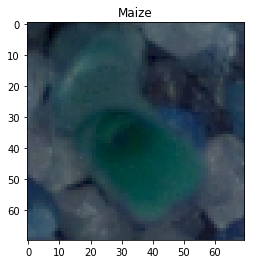

In [3]:
# Displaying an image
plt.title(train_Y[0][100])
_ = plt.imshow(train_X[100])

In [4]:
# Converting labels to numbers
encoder = LabelEncoder()
encoder.fit(train_Y[0])
encoded_labels = encoder.transform(train_Y[0])
categorical_labels = np_utils.to_categorical(encoded_labels)

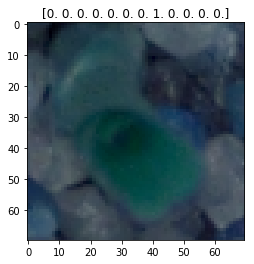

In [5]:
plt.title(str(categorical_labels[100]))
_ = plt.imshow(train_X[100])

In [6]:
x_train,x_test,y_train,y_test=train_test_split(train_X,categorical_labels,test_size=0.25,random_state=7)
#print(x_train.shape,x_test.shape)


In [7]:
import keras
from keras import layers
from keras.layers import Input, Dense, Activation,ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16

In [8]:
base_model = VGG16(include_top=False, weights='imagenet', input_shape=(70, 70, 3))

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 1s 0us/step


In [9]:
model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(12, activation='sigmoid'))

In [10]:
opt = keras.optimizers.adam(lr=0.0001, decay=1e-6)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)

In [12]:
datagen.fit(x_train)

In [13]:
model.fit_generator(datagen.flow(x_train, y_train,
                                    batch_size=50),
                    steps_per_epoch=x_train.shape[0],
                    epochs=1,
                    validation_data=(x_test, y_test),
                    verbose=1)     


Instructions for updating:
Use tf.cast instead.
Epoch 1/1
3562/3562 [==============================] - 311s 87ms/step - loss: 0.2177 - acc: 0.9203 - val_loss: 0.3882 - val_acc: 0.9217


In [14]:
[loss, accuracy] = model.evaluate(x_test, y_test)

1188/1188 [==============================] - 1s 599us/step


In [15]:
print('Test Set Accuracy: '+str(accuracy*100)+"%");

Test Set Accuracy: 92.17171717171718%


In [27]:
test_images_path = '../input/test/*.png'
test_images = glob(test_images_path)
test_images_arr = []
test_files = []

for img in test_images:
    test_images_arr.append(cv2.resize(cv2.imread(img), (70, 70)))
    test_files.append(img.split('/')[-1])

test_X = np.asarray(test_images_arr)

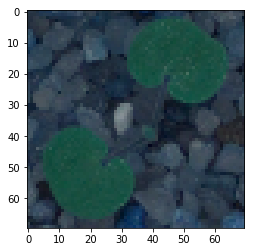

In [28]:
_ = plt.imshow(test_X[100])

In [29]:
predictions = model.predict(test_X)

In [30]:
preds = np.argmax(predictions, axis=1)
pred_str = encoder.classes_[preds]

In [32]:
final_predictions = {'file':test_files, 'species':pred_str}
final_predictions = pd.DataFrame(final_predictions)
final_predictions.to_csv("submission.csv", index=False)